<a href="https://colab.research.google.com/github/ishmalhotra/netflix-customer-segmentation-rfm/blob/main/Netflix_rfm_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd

from google.colab import files
uploaded = files.upload()

Saving netflix_rfm_sample_data.csv to netflix_rfm_sample_data.csv


In [4]:
netflix = pd.read_csv('netflix_rfm_sample_data.csv')

In [5]:
netflix.sample(5)

,customer_id,subscription_date,last_activity_date,plan_type,monthly_price,total_payment,total_watch_hours,region,total_sessions
1595,CUST1695,2024-05-08,2024-08-11,Premium,15.99,46.37,181.8,US,159
561,CUST661,2025-01-18,2025-06-17,Standard,10.99,57.55,250.8,US,190
396,CUST496,2023-10-25,2025-07-15,Standard,10.99,218.96,1096.8,France,1080
489,CUST589,2023-10-02,2025-07-03,Basic,6.99,136.22,1369.5,US,567
372,CUST472,2025-04-11,2025-06-28,Standard,10.99,23.18,77.6,France,66


In [6]:
netflix['subscription_date'] = pd.to_datetime(netflix['subscription_date'])
netflix['last_activity_date']= pd.to_datetime(netflix['last_activity_date'])

In [7]:
import datetime
snapshot_date = datetime.datetime(2025, 9, 30)

In [8]:
netflix['Recency']= snapshot_date - netflix['last_activity_date']
netflix['Frequency']= netflix['total_sessions']
netflix['Monetary']= netflix['total_payment'].round(2)

netflix_rfm = netflix[['customer_id', 'Recency', 'Frequency', 'Monetary']].copy()
netflix_rfm.head()

,customer_id,Recency,Frequency,Monetary
0,CUST100,340 days,34,6.30
1,CUST101,218 days,882,272.94
2,CUST102,105 days,357,119.06
3,CUST103,78 days,826,218.49
4,CUST104,103 days,72,20.75


In [9]:
R_labels = [5,4,3,2,1]
F_labels = [1,2,3,4,5]
M_labels = [1,2,3,4,5]

In [10]:
netflix_rfm['Recency_Score']= pd.qcut(netflix_rfm['Recency'], q = 5, labels = R_labels)
netflix_rfm['Frequency_Score']= pd.qcut(netflix_rfm['Frequency'], q = 5, labels = F_labels)
netflix_rfm['Monetary_Score']= pd.qcut(netflix_rfm['Monetary'], q = 5, labels = M_labels)

In [11]:
netflix_rfm.head()

,customer_id,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score
0,CUST100,340 days,34,6.30,1,1,1
1,CUST101,218 days,882,272.94,2,5,5
2,CUST102,105 days,357,119.06,3,3,4
3,CUST103,78 days,826,218.49,5,5,5
4,CUST104,103 days,72,20.75,3,1,1


In [12]:
netflix_rfm['RFM_Score']= (netflix_rfm['Recency_Score'].astype(int)*0.5+netflix_rfm['Frequency_Score'].astype(int)*0.3+netflix_rfm['Monetary_Score'].astype(int)*0.2).round(2)
netflix_rfm.head()

,customer_id,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score
0,CUST100,340 days,34,6.30,1,1,1,1.0
1,CUST101,218 days,882,272.94,2,5,5,3.5
2,CUST102,105 days,357,119.06,3,3,4,3.2
3,CUST103,78 days,826,218.49,5,5,5,5.0
4,CUST104,103 days,72,20.75,3,1,1,2.0


In [16]:
def assign_score(score):
  if score >=4.7:
    return 'VIP'
  elif score >=4.0:
    return 'Loyal'
  elif score >=3.0:
    return 'Average'
  elif score >=2.0:
    return 'At Risk'
  else:
    return 'Inactive'

In [17]:
netflix_rfm['Customer_segment'] = netflix_rfm['RFM_Score'].apply(assign_score)

netflix_rfm['Customer_segment'].value_counts().copy()

,count
Customer_segment,
Average,557
At Risk,428
Loyal,367
Inactive,331
VIP,117


In [18]:
netflix_rfm['CLV'] = (netflix_rfm['Monetary'] * (1/0.1)).round(2)
netflix_rfm.head()

,customer_id,Recency,Frequency,Monetary,Recency_Score,Frequency_Score,Monetary_Score,RFM_Score,CLV,Customer_segment
0,CUST100,340 days,34,6.30,1,1,1,1.0,63.0,Inactive
1,CUST101,218 days,882,272.94,2,5,5,3.5,2729.4,Average
2,CUST102,105 days,357,119.06,3,3,4,3.2,1190.6,Average
3,CUST103,78 days,826,218.49,5,5,5,5.0,2184.9,VIP
4,CUST104,103 days,72,20.75,3,1,1,2.0,207.5,At Risk


/tmp/ipython-input-19-629532544.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = netflix_rfm.pivot_table(index='Recency_Score',


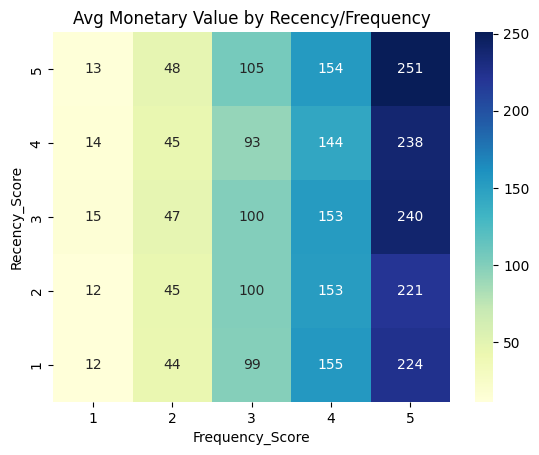

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = netflix_rfm.pivot_table(index='Recency_Score',
                             columns='Frequency_Score',
                             values='Monetary',
                             aggfunc='mean')

sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Avg Monetary Value by Recency/Frequency')
plt.savefig("netflix_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [29]:
from google.colab import files
files.download("netflix_heatmap.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

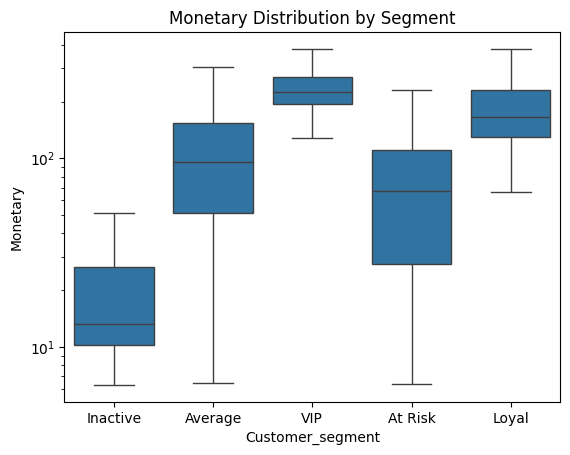

In [21]:
sns.boxplot(x='Customer_segment', y='Monetary', data=netflix_rfm, showfliers=False)
plt.yscale('log')  # For skewed monetary values
plt.title('Monetary Distribution by Segment')
plt.savefig("netflix_segments.png", dpi=300, bbox_inches='tight')
plt.show()

In [22]:
action_rules = {
    'VIP': "Offer exclusive content + loyalty rewards",
    'Loyal': "Upsell to premium plan + referral program",
    'Average': "Re-engagement emails + limited-time discounts",
    'At Risk': "Win-back campaign + survey for feedback",
    'Inactive':"Reactivation campaign (1-month free)+Churn postmortem"
}

netflix_rfm['Next_Best_Action'] = netflix_rfm['Customer_segment'].map(action_rules)

In [23]:
# Columns to include in final analysis
output_cols = [
    'customer_id', 'Customer_segment', 'RFM_Score',
    'CLV', 'Next_Best_Action',
    'Recency', 'Frequency', 'Monetary'
]

final_output = netflix_rfm[output_cols].sort_values('CLV', ascending=False)


In [24]:

key_metrics = netflix_rfm.groupby('Customer_segment').agg({
    'CLV': 'mean',
    'Recency': 'median',
    'Frequency': 'mean',
    'Monetary': 'sum'
}).rename(columns={'Monetary': 'Total_Revenue'})
print(key_metrics)

                          CLV           Recency   Frequency  Total_Revenue
Customer_segment                                                          
At Risk            757.082477 201 days 12:00:00  272.551402       32403.13
Average           1093.051167  97 days 00:00:00  404.877917       60882.95
Inactive           217.346828 245 days 00:00:00   82.927492        7194.18
Loyal             1847.332970  90 days 00:00:00  668.356948       67797.12
VIP               2432.784615  81 days 00:00:00  842.034188       28463.58


In [25]:
segment_dist = netflix_rfm['Customer_segment'].value_counts(normalize=True).round(2)
print(f"Segment Distribution:\n{segment_dist}")

Segment Distribution:
Customer_segment
Average     0.31
At Risk     0.24
Loyal       0.20
Inactive    0.18
VIP         0.06
Name: proportion, dtype: float64


In [26]:
netflix_rfm['plan_type'] = netflix['plan_type']

import plotly.express as px

fig = px.sunburst(netflix_rfm, path=['Customer_segment', 'plan_type'], values='CLV')
fig.update_layout(title='CLV by Segment & Plan')
fig.show()

In [27]:
netflix_rfm.to_csv('netflix_rfm_result.csv', index=False)

In [28]:
from google.colab import files
files.download('netflix_rfm_result.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>